In [1]:
%reset -f
# Generic modules:
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dtime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os.path
import time
%matplotlib inline

# Refnx modules:
import refnx, scipy
from refnx.reflect import SLD, ReflectModel, Slab, Structure, LipidLeaflet

# Modules for profiling:
import cProfile, pstats, io

# Global vars:
WAVELENGTH = 1.00
THETA_VALUES = np.linspace(0.0,10,1025)
Q_VALUES = 4.0*np.pi*np.sin(THETA_VALUES*np.pi/180.0)/WAVELENGTH
N_LAYERS = 10

In [2]:
def refnx_reflectivity(structure,qvals):
    return ReflectModel(structure, scale=1.0, bkg=0.0, dq=0.0).model(qvals)

def run_refnx_model(num_bilayers,qvals):
    # set up the SLD objects for each layer
    sld_air = SLD(0.0 + 0.0j, name='air')
    sld_Ti = SLD(-1.9493 + 0.0j, name='Ti')
    sld_Ni = SLD(9.4245 + 0.0j, name='Ni')
    sld_Si = SLD(2.0704 +  0.0j, name='Si')
    
    # set up the Slab objects for each layer
    slab_air = Slab(0.0, sld_air, 0.0, name='air_slab')
    slab_Ti =  Slab(30.0, sld_Ti, 0.0, name ='Ti_slab')
    slab_Ni =  Slab(70.0, sld_Ni, 0.0, name ='Ni_slab')
    slab_Si =  Slab(0.0, sld_Si, 0.0, name ='Si_slab')

    # set up the Structure object from the Slabs
    structure = Structure()
    
    structure.append(slab_air)
    for i in range(num_bilayers):
        structure.append(slab_Ti)
        structure.append(slab_Ni)
    structure.append(slab_Si)
    
    reflectivity_values = refnx_reflectivity(structure,qvals)
    
    return reflectivity_values

In [3]:
y = run_refnx_model(1,Q_VALUES)

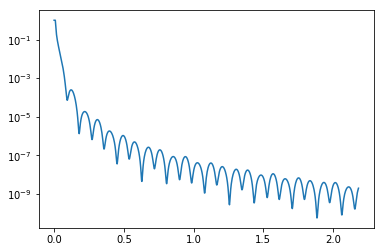

In [4]:
plt.semilogy(Q_VALUES,y)

In [5]:
kiesing_indices = []
crest_indices = []
for i in range(1,len(y)-1):
    y_1 = y[i-1]
    y0 = y[i]
    y1 = y[i+1]
    if( y_1 > y0 and y0 < y1 ):
        kiesing_indices.append(i)
    if( y_1 < y0 and y0 > y1 ):
        crest_indices.append(i)


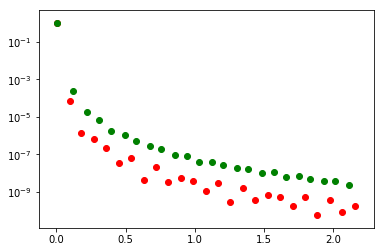

In [6]:
plt.semilogy(Q_VALUES,y,alpha=0.0)
plt.scatter(Q_VALUES[kiesing_indices],y[kiesing_indices],c='r')
plt.scatter(Q_VALUES[crest_indices],y[crest_indices],c='g')

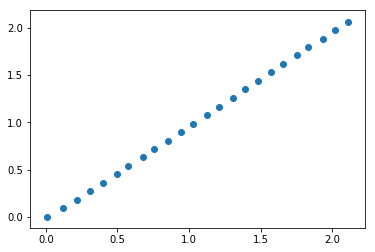

In [7]:
plt.scatter(Q_VALUES[crest_indices],Q_VALUES[kiesing_indices[:len(crest_indices)]])

highTiNi = Q_VALUES[crest_indices]
lowTiNi = Q_VALUES[kiesing_indices]

In [8]:
def run_two_slds(sld1,sld2):
    # set up the SLD objects for each layer
    sld_air = SLD(0.0 + 0.0j, name='air')
    sld_1 = SLD(sld1 + 0.0j, name='Ti')
    sld_2 = SLD(sld2 + 0.0j, name='Ni')
    sld_Si = SLD(2.0704 +  0.0j, name='Si')
    
    # set up the Slab objects for each layer
    slab_air = Slab(0.0, sld_air, 0.0, name='air_slab')
    slab_1 =  Slab(30.0, sld_1, 0.0, name ='Ti_slab')
    slab_2 =  Slab(70.0, sld_2, 0.0, name ='Ni_slab')
    slab_Si =  Slab(0.0, sld_Si, 0.0, name ='Si_slab')

    # set up the Structure object from the Slabs
    structure = Structure()
    
    structure.append(slab_air)
    for i in range(1):
        structure.append(slab_1)
        structure.append(slab_2)
    structure.append(slab_Si)
    
    reflectivity_values = refnx_reflectivity(structure,Q_VALUES)
    
    return reflectivity_values

In [9]:
s1 = -2.0
s2 =  9.0
r = run_two_slds(s1,s2)

In [10]:
def take_fingerprint(y):
    kiesing_indices = []
    crest_indices = []
    for i in range(1,len(y)-1):
        y_1 = y[i-1]
        y0 = y[i]
        y1 = y[i+1]
        if( y_1 > y0 and y0 < y1 ):
            kiesing_indices.append(i)
        if( y_1 < y0 and y0 > y1 ):
            crest_indices.append(i)
    return kiesing_indices, crest_indices

In [11]:
idx_low, idx_high = take_fingerprint(r)

In [12]:
low = Q_VALUES[idx_low]
high = Q_VALUES[idx_high]


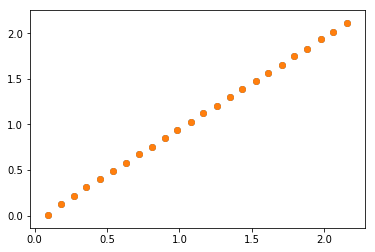

In [13]:
plt.scatter(low,high[1:])
plt.scatter(lowTiNi[1:],highTiNi)

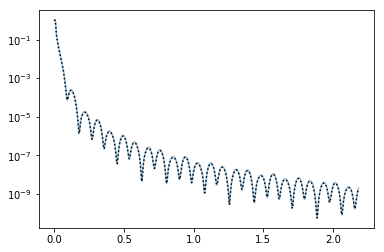

In [14]:
plt.semilogy(Q_VALUES,y, alpha=0.5)
plt.semilogy(Q_VALUES,r,'k:')

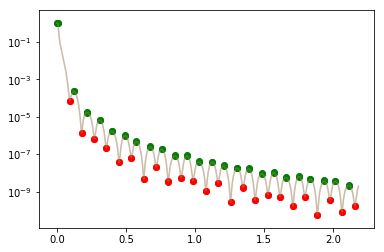

In [15]:
plt.semilogy(Q_VALUES,y,alpha=0.3)
plt.scatter(lowTiNi,y[kiesing_indices],c='r')
plt.scatter(highTiNi,y[crest_indices],c='g')

plt.semilogy(Q_VALUES,r,alpha=0.3)
plt.scatter(low,r[idx_low],c='r')
plt.scatter(high,r[idx_high],c='g')

In [16]:
print(low)
print(lowTiNi)

[0.09424013 0.17990852 0.27199259 0.35763919 0.45183109 0.53957805
 0.62943782 0.71926534 0.80691859 0.8988052  0.98637312 1.07816082
 1.16562547 1.25729545 1.34676841 1.43404453 1.52762869 1.61475488
 1.70816833 1.79512632 1.88411431 1.97512099 2.06179606 2.15681119]
[0.00428368 0.09424013 0.17990852 0.27199259 0.35763919 0.45183109
 0.53957805 0.62943782 0.71926534 0.80691859 0.8988052  0.98637312
 1.07816082 1.16562547 1.25729545 1.34676841 1.43404453 1.52762869
 1.61475488 1.70816833 1.79512632 1.88411431 1.97512099 2.06390885
 2.15681119]


In [17]:
def run_sld_thicknes_roughness(slds,thicknesses,roughnesses,qvals):
    assert len(slds) == len(thicknesses), "slds and thicknesses have different lengths"
    assert len(slds) == len(roughnesses), "slds and roughnesses have different lengths"
    
    structure = Structure()
    for i in range(len(slds)):
        m_sld = SLD(slds[i], name='sld'+str(i))
        slab = Slab(thicknesses[i], m_sld, roughnesses[i], name='slab'+str(i))
        structure.append(slab)
    
    reflectivity_values = refnx_reflectivity(structure,qvals)
    
    return reflectivity_values

# Single layer immersed in air:

In [18]:
def run_single_layer(s,th,q):
    slds = [0., s, 0]
    thicknesses = [0., th, 0.]
    roughnesses = [0.,  0., 0.]
    r = run_sld_thicknes_roughness(slds,thicknesses,roughnesses,q)
    return r

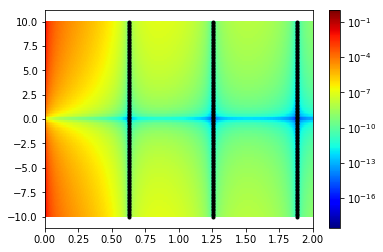

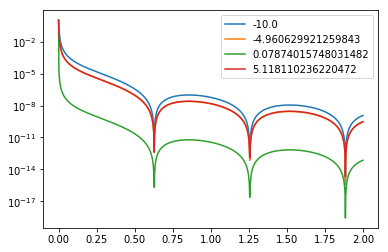

In [19]:
#Single Layer, varying SLD

qvals = np.linspace(0,2,1025)
refs = []
slds = []
fingerprints = {}
thickness = 10.
for sld in np.linspace(-10.,10.,128):
    slds.append(sld)
    ref = run_single_layer(sld,thickness,qvals)
    refs.append(ref)
    low, high = take_fingerprint(ref)
    fingerprints[sld] = qvals[low]
refs = np.asarray(refs)
slds = np.asarray(slds)
qvals = np.asarray(qvals)

import matplotlib.colors as colors
xx, yy = np.meshgrid(qvals, slds)
# Make the plot
plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=refs.min(), vmax=refs.max()), cmap='jet')
plt.colorbar()
for s in slds:
    plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.') 
plt.show()

for i in range(0,len(slds),len(slds)//4):
    plt.semilogy(qvals,refs[i], label = str(slds[i]))
plt.legend()
plt.show()


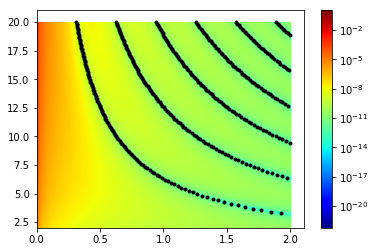

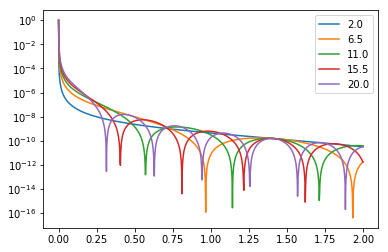

In [20]:
#Single Layer, varying thickness

qvals = np.linspace(0,2,1025)
refs = []
thicknesses = []
fingerprints = {}
sld = 1.
for thickness in np.linspace(2,20,129):
    thicknesses.append(thickness)
    ref = run_single_layer(sld,thickness,qvals)
    refs.append(ref)
    low, high = take_fingerprint(ref)
    fingerprints[thickness] = qvals[low]
refs = np.asarray(refs)
thicknesses = np.asarray(thicknesses)
qvals = np.asarray(qvals)

import matplotlib.colors as colors
xx, yy = np.meshgrid(qvals, thicknesses)
# Make the plot
plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=refs.min(), vmax=refs.max()), cmap='jet')
plt.colorbar()
for s in thicknesses:
    plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.') 
plt.show()

for i in range(0,len(thicknesses),len(thicknesses)//4):
    plt.semilogy(qvals,refs[i], label = str(thicknesses[i]))
plt.legend()
plt.show()

# Substrate only: semi-infinite slab

In [21]:
def run_substrate_only(s,th,q):
    slds = [0., s]
    thicknesses = [0., 0.]
    roughnesses = [0., 0.]
    r = run_sld_thicknes_roughness(slds,thicknesses,roughnesses,q)
    return r

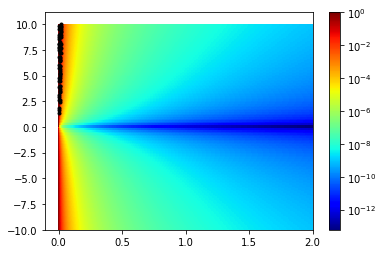

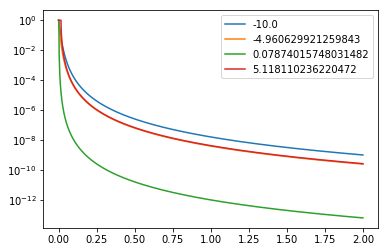

In [22]:
qvals = np.linspace(0,2,1025)
refs = []
slds = []
fingerprints = {}
thickness = 10.
for sld in np.linspace(-10.,10.,128):
    slds.append(sld)
    ref = run_substrate_only(sld,thickness,qvals)
    refs.append(ref)
    low, high = take_fingerprint(ref)
    fingerprints[sld] = qvals[low]
refs = np.asarray(refs)
slds = np.asarray(slds)
qvals = np.asarray(qvals)

import matplotlib.colors as colors
xx, yy = np.meshgrid(qvals, slds)
# Make the plot
plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=refs.min(), vmax=refs.max()), cmap='jet')
plt.colorbar()
for s in slds:
    plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.') 
plt.show()

for i in range(0,len(slds),len(slds)//4):
    plt.semilogy(qvals,refs[i], label = str(slds[i]))
plt.legend()
plt.show()

# Substrate + layer:

In [23]:
def run_layer_over_substrate(layer_sld, substrate_sld,layer_thickness,q):
    slds = [0., layer_sld, substrate_sld]
    thicknesses = [0., layer_thickness, 0.]
    roughnesses = [0.,  0., 0.]
    r = run_sld_thicknes_roughness(slds,thicknesses,roughnesses,q)
    return r

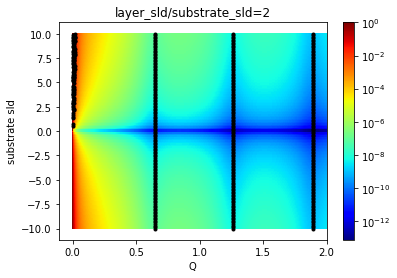

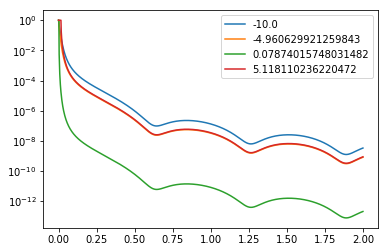

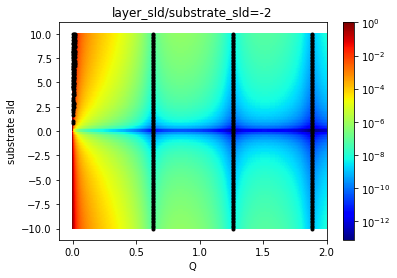

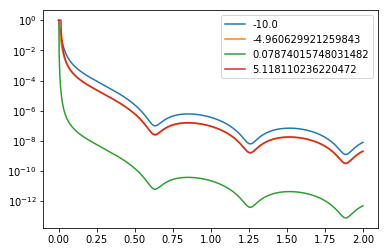

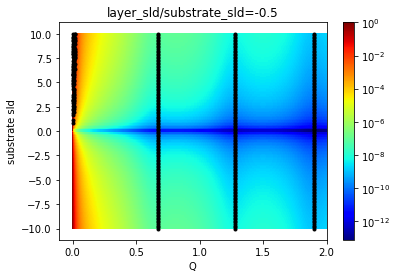

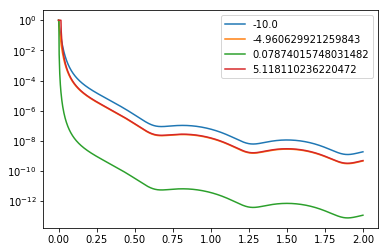

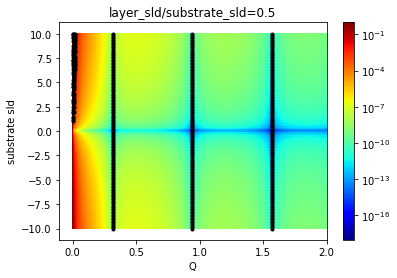

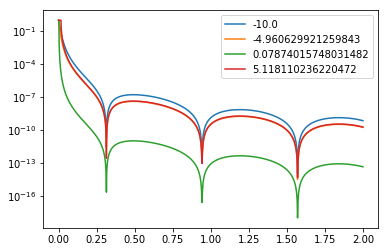

In [24]:
#Same thickness, varying sld:
def run_layer_over_substrate_with_sld_factor(factor):
    qvals = np.linspace(0,2,1025)
    refs = []
    slds = []
    fingerprints = {}
    thickness = 10.
    for sld in np.linspace(-10.,10.,128):
        slds.append(sld)
        ref = run_layer_over_substrate(factor*sld, sld,thickness,qvals)
        refs.append(ref)
        low, high = take_fingerprint(ref)
        fingerprints[sld] = qvals[low]
    refs = np.asarray(refs)
    slds = np.asarray(slds)
    qvals = np.asarray(qvals)
    
    import matplotlib.colors as colors
    xx, yy = np.meshgrid(qvals, slds)
    # Make the plot
    plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=refs.min(), vmax=refs.max()), cmap='jet')
    plt.colorbar()
    for s in slds:
        plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.') 
    plt.title("layer_sld/substrate_sld="+str(factor))
    plt.xlabel("Q")
    plt.ylabel("substrate sld")
    plt.show()
    
    for i in range(0,len(slds),len(slds)//4):
        plt.semilogy(qvals,refs[i], label = str(slds[i]))
    plt.legend()
    plt.show()
    
for f in [2,-2,-0.5,0.5]:
    run_layer_over_substrate_with_sld_factor(f)

KeyboardInterrupt: 

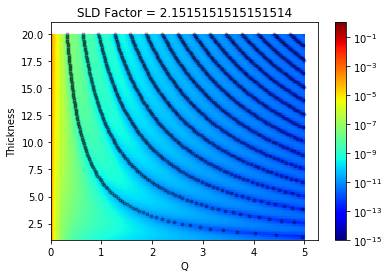

In [25]:
qvals = np.linspace(0,5,1025)
thicknesses = np.linspace(1,20,129)

sld = 1.
for count, f in enumerate(np.linspace(-3.0,3.0,100)):
    
    refs = []
    fingerprints = {}
    for thickness in thicknesses:
        ref = run_layer_over_substrate(f*sld,sld,thickness,qvals)
        refs.append(ref)
        low, high = take_fingerprint(ref)
        fingerprints[thickness] = qvals[low]
    refs = np.asarray(refs)
    qvals = np.asarray(qvals)
    
    import matplotlib.colors as colors
    xx, yy = np.meshgrid(qvals, thicknesses)
    # Make the plot
    plt.figure()
    plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=1e-15, vmax=1.1), cmap='jet')
    plt.colorbar()
    for s in thicknesses:
        plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.', alpha=0.3) 
    plt.xlabel("Q")
    plt.ylabel("Thickness")
    plt.title("SLD Factor = " + str(f))
    plt.savefig("ConstantSLDfactorColormap_{:02}.png".format(count))
    #plt.show()
    plt.close(fig='all')
    
    plt.figure()
    for i in range(0,len(thicknesses),len(thicknesses)//4):
        plt.semilogy(qvals,refs[i], label = str(thicknesses[i]))
    
    multiplier = abs(1-f) * np.exp(abs(-f+f/2))
    plt.semilogy(qvals[1:],multiplier*(qvals[1:]/qvals[1])**-4,'k')
    plt.semilogy(qvals[1:],np.exp(-1.5)*(qvals[1:]/qvals[1])**-4,'k')
    plt.title("SLD Factor = " + str(f))
    plt.xlabel("Q")
    plt.ylabel("R")
    plt.legend()
    
    plt.savefig("ConstantSLDfactorRefCurve_{:02}.png".format(count))
    plt.close(fig='all')
    #plt.show()

In [ ]:
qvals = np.linspace(0,5,1025)
sld = 1.

factors = np.concatenate([
    np.linspace(-3.,0.,128, endpoint=False),
    np.linspace(1.0/128.,1.,128, endpoint=False),
    np.linspace(1.,3.,128)
]
)

for count, thickness in enumerate(np.linspace(0.1,10,100)):

    refs = []
    fingerprints = {}
    for factor in factors:
        ref = run_layer_over_substrate(factor*sld,sld,thickness,qvals)
        refs.append(ref)
        low, high = take_fingerprint(ref)
        fingerprints[factor] = qvals[low]
    refs = np.asarray(refs)
    qvals = np.asarray(qvals)
    
    import matplotlib.colors as colors
    xx, yy = np.meshgrid(qvals, factors)
    # Make the plot
    
    plt.figure()
    plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=1e-15, vmax=1.1), cmap='jet')
    plt.colorbar()
    for s in factors:
        plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.', alpha=0.01) 
    plt.axhline(1.0, c='k', alpha=0.3)
    plt.axhline(0.0, c='k',alpha=0.3)
    plt.xlabel("$Q[\AA]$")
    plt.ylabel("f = layer sld / substrate sld")
    plt.title("Thickness = "+str(thickness))
    plt.savefig("ThicknessColorMap_{:02}.png".format(count))
    plt.close(fig='all')
    
    plt.figure()
    for i in range(0,len(factors)):
        if factors[i] < 0:
            plt.semilogy(qvals,1e-2*refs[i], "r", label = str(factors[i]))
        elif factors[i] < 1:
            plt.semilogy(qvals,1e-4*refs[i], "g", label = str(factors[i]))
        else:
            plt.semilogy(qvals,refs[i], "b", label = str(factors[i]))
    
    plt.xlabel("$Q[\AA]$")
    plt.ylabel("$R$")
    plt.title("Green: 0 < f < 1; Red: f < 0; Blue: f > 1; Th = "+str(thickness))
    plt.savefig("ThicknessRefCurve_{:02}.png".format(count))
    #plt.legend()
    plt.close(fig='all')

In [27]:
def run_layers_over_substrate(substrate_sld, layers_slds,layers_thicknesses,q):
    slds = [0.] + layers_slds + [substrate_sld]
    thicknesses = [0.] + layers_thicknesses + [0.]
    roughnesses = [0. for _ in thicknesses]
    r = run_sld_thicknes_roughness(slds,thicknesses,roughnesses,q)
    return r

# Self-Similarity of the problem:

 - ### Rescaling to $Q$:

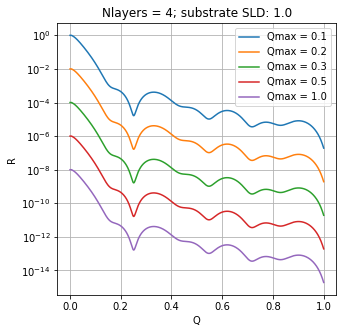

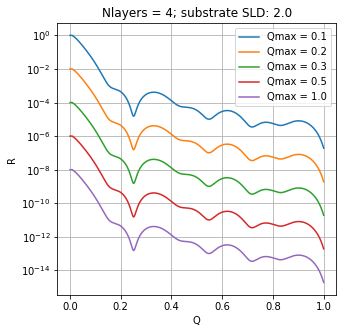

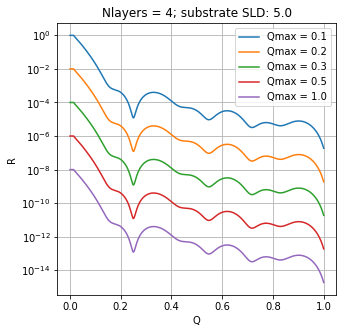

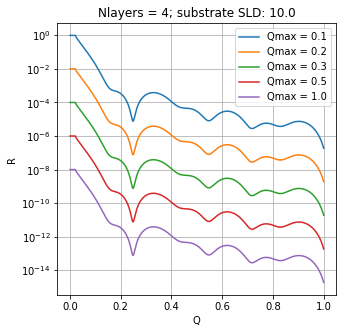

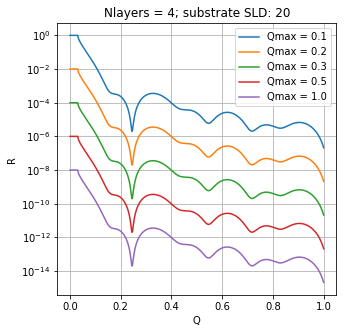

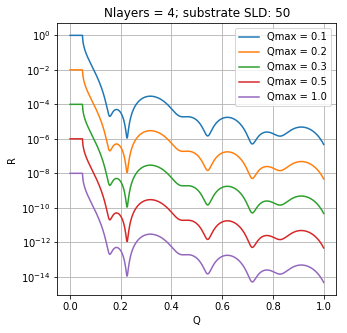

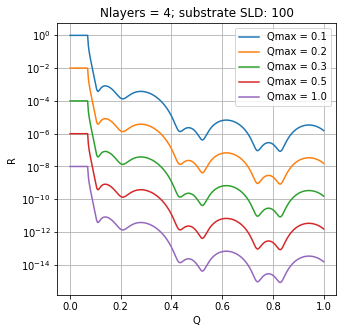

In [28]:
countfig = 0
power = 2.0
for substrate_sld in [1.0, 2.0, 5.0, 10.0, 20, 50, 100]:
    plt.figure(figsize=(5,5))
    plot_shift = 1.0
    for qmax in [ 0.10, 0.20, 0.30, 0.50, 1.00]:
        qvals = qmax * np.linspace(1e-3, 1.0, 1025)
        
        #rescale to qmax
        sub_sld = substrate_sld * qmax**2
        layers_slds = [qmax**2 * x for x in [30,70,50,90]]
        layers_thicknesses = [qmax**(-1) * x for x in [20,10,10, 5]]

        ref_signal = run_layers_over_substrate(sub_sld,layers_slds,layers_thicknesses,qvals)
    
        qvals /= qmax
        plt.semilogy(qvals,ref_signal*plot_shift, label = "Qmax = " + str(qmax))
        plot_shift *= 0.01
    
    
    plt.legend()
    plt.xlabel("Q")
    plt.ylabel("R")
    
    #plt.ylim([1e-7,1e-3])
    #plt.xlim([0.4,0.8])
    
    plt.title("Nlayers = " + str(len(layers_slds)) + "; substrate SLD: " + str(substrate_sld) )
    plt.grid()
    #plt.savefig("fig_{:02}.png".format(countfig))
    #plt.close(fig='all')
    plt.show()
    countfig+=1

 - ### Rescaling to $\rho_{\rm substrate}$:

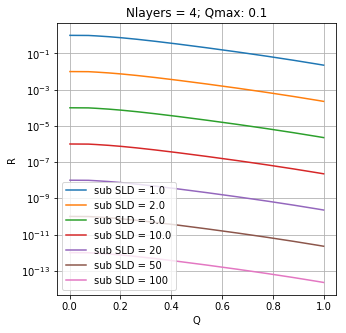

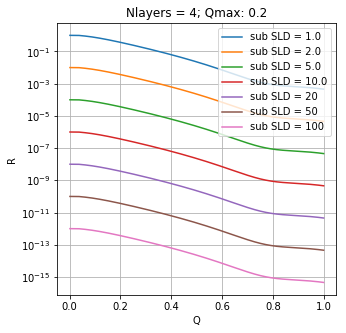

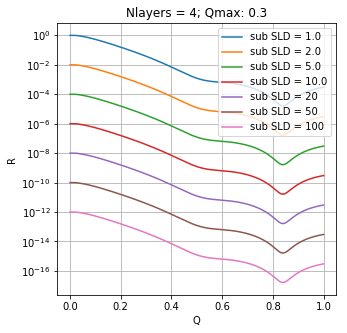

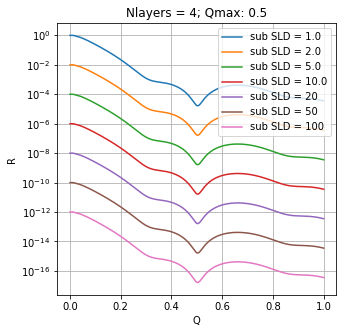

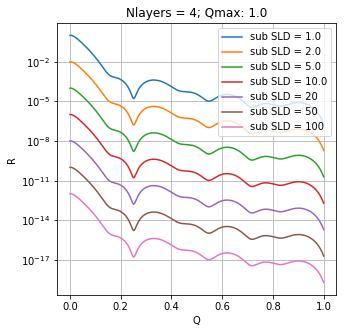

In [29]:
countfig = 0
power = 2.0
for qmax in [ 0.10, 0.20, 0.30, 0.50, 1.00]:
    plt.figure(figsize=(5,5))
    plot_shift = 1.0
    
    for substrate_sld in [1.0, 2.0, 5.0, 10.0, 20, 50, 100]:        
        
        #rescale to substrate_sld:
        scale_factor = np.sqrt(substrate_sld)
        qvals = scale_factor * qmax * np.linspace(1e-3, 1.0, 1025)
        layers_slds = [scale_factor**2 * x for x in [30,70,50,90]]
        layers_thicknesses = [scale_factor**(-1) * x for x in [20,10,10, 5]]

        ref_signal = run_layers_over_substrate(substrate_sld,layers_slds,layers_thicknesses,qvals)
    
        qvals /= (scale_factor*qmax)
        plt.semilogy(qvals,ref_signal*plot_shift, label = "sub SLD = " + str(substrate_sld))
        plot_shift *= 0.01
    
    
    plt.legend()
    plt.xlabel("Q")
    plt.ylabel("R")
    
    #plt.ylim([1e-7,1e-3])
    #plt.xlim([0.4,0.8])
    
    plt.title("Nlayers = " + str(len(layers_slds)) + "; Qmax: " + str(qmax) )
    plt.grid()
    #plt.savefig("fig_{:02}.png".format(countfig))
    #plt.close(fig='all')
    plt.show()
    countfig+=1

# Rescaling an experiment to fit the "unitless model":

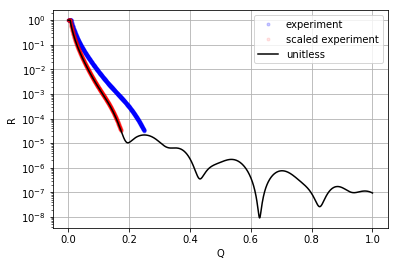

In [146]:
#### Experiment:

subs_from_experiment = 2.07
q_from_experiment = np.linspace(1e-3, 0.25, 1025)
slds_from_experiment = [x*subs_from_experiment for x in [20., 10, 4, 2]] #unknown
thicks_from_experiment = [x/np.sqrt(subs_from_experiment) for x in [30., 10, 20, 15]] #unknown
ref_from_experiment = run_layers_over_substrate(subs_from_experiment, 
                                                slds_from_experiment, 
                                                thicks_from_experiment,
                                                q_from_experiment)

### Experiment rescaled:

scaled_subs_sld = 1.0 # by definition is 1.0
scale_factor = np.sqrt(subs_from_experiment)
scaled_q = q_from_experiment / scale_factor
scaled_slds = [x / (scale_factor**2) for x in slds_from_experiment]
scaled_thicks = [x * scale_factor for x in thicks_from_experiment]
scaled_ref = run_layers_over_substrate(scaled_subs_sld, 
                                                scaled_slds, 
                                                scaled_thicks,
                                                scaled_q)

### Unitless model:

unit_sld_substrate = 1.0
unit_q = np.linspace(0.0, 1.0, 1025)
unitless_layer_slds = [x for x in [20., 10, 4, 2]] # We have to guess these numbers
unitless_layer_thicknesses = [x for x in [30., 10, 20, 15]] # We have to guess these numbers

unitless_reflectometry = run_layers_over_substrate(unit_sld_substrate, 
                                                unitless_layer_slds,
                                                unitless_layer_thicknesses,
                                                unit_q)


# compare experiment with unitless model

plt.semilogy(q_from_experiment, ref_from_experiment, 'b.' ,label = "experiment", alpha = 0.2)
plt.semilogy(scaled_q, scaled_ref, 'r.' ,label = "scaled experiment", alpha = 0.1)
plt.semilogy(unit_q, unitless_reflectometry, 'k-' ,label = "unitless")


plt.legend()
plt.xlabel("Q")
plt.ylabel("R")

plt.grid()
plt.show()

# The period depends on the thickness and the amplitude on the SLD:

 - In the natural units defined by the sld of the substrate, the kiessing finges appear with a period $\Delta Q = 2\pi / d$, where $d$ is the thickness of the layer; i.e. thicker layers produce more fringes for the same $Q$ range.
 - The amplitude of the $RQ^4$ signal evidently has a dependence on the sld of the layer on top of the substrate. In this simple example, we use two envelope functions for modelling the top and the bottom of the signal: a constant $1.5 \times 10^{-10}$ for the lower envelope and a function $ \sim \rho_{\rm layer}^2$ for the upper layer. 

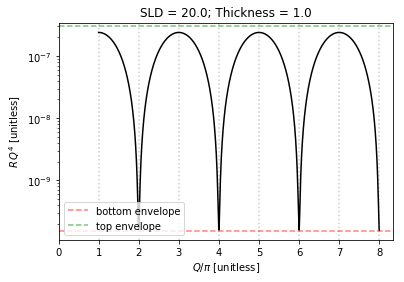

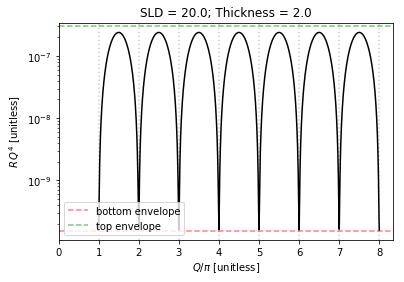

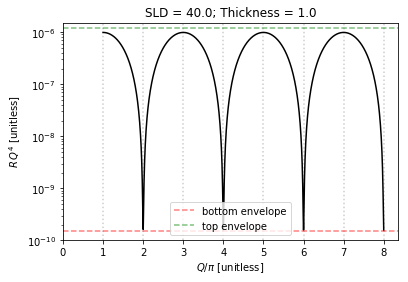

In [93]:
def plot_rq4(layer_sld, layer_thickness):

    unit_sld_substrate = 1.0
    unit_q = np.linspace(np.pi, 8.0*np.pi, 2049)
    unitless_layer_slds = [x for x in [layer_sld]] # We have to guess these numbers
    unitless_layer_thicknesses = [x for x in [layer_thickness]] # We have to guess these numbers
    
    unitless_reflectometry = run_layers_over_substrate(unit_sld_substrate, 
                                                    unitless_layer_slds,
                                                    unitless_layer_thicknesses,
                                                    unit_q)
    
    plt.semilogy(unit_q/np.pi, unit_q**4*unitless_reflectometry, 'k-')
    xmarks = [x for x in range(9)]
    plt.xticks(xmarks)
    for tick in xmarks:
        plt.axvline(tick, c='k', ls=':', alpha = 0.2)
        
    plt.axhline(1.5e-10, c='r', ls='--', alpha = 0.5, label = "bottom envelope")
    plt.axhline(7.5e-10*layer_sld**2, c='g', ls='--', alpha = 0.5, label = "top envelope")
    plt.xlabel("$Q / \pi \,\, [{\\rm unitless}]$")
    plt.ylabel("$R\,Q^4 \,\, [{\\rm unitless}]$")
    plt.legend()
    plt.title("SLD = {}; Thickness = {}".format(layer_sld, layer_thickness))
    plt.show()



#LAYER_SLD = 13.0
#LAYER_THICKNESS = 1.0

plot_rq4(20.0,1.0)
plot_rq4(20.0,2.0)
plot_rq4(40.0,1.0)





# The envelopes of the signal:

The top and the bottom envelopes of the $RQ^4$ signal vary as function of the layer SLD. The following cell shows this variation

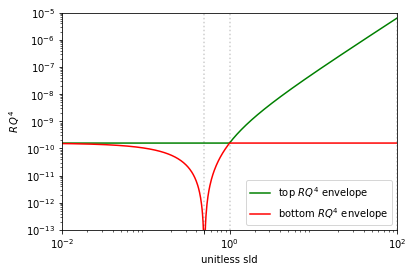

In [95]:
LAYER_THICKNESS = 1.0
peaks = []
valleys = []
layer_slds = []
for LAYER_SLD in np.logspace(-3,3,1025):
    unit_sld_substrate = 1.0
    unit_q = np.linspace(2.0*np.pi, 8.0*np.pi, 2049)
    unitless_layer_slds = [x for x in [LAYER_SLD]] # We have to guess these numbers
    unitless_layer_thicknesses = [x for x in [LAYER_THICKNESS]] # We have to guess these numbers
    
    unitless_reflectometry = run_layers_over_substrate(unit_sld_substrate, 
                                                unitless_layer_slds,
                                                unitless_layer_thicknesses,
                                                unit_q)

    peak = max(unit_q**4*unitless_reflectometry)
    valley = min(unit_q**4*unitless_reflectometry)
    peaks.append(peak)
    valleys.append(valley)
    layer_slds.append(LAYER_SLD)

peaks = np.asarray(peaks)
valleys = np.asarray(valleys)
layer_slds = np.asarray(layer_slds)

plt.loglog(layer_slds,peaks, 'g-', label = "top $RQ^4$ envelope")
plt.loglog(layer_slds,valleys, 'r-', label = "bottom $RQ^4$ envelope")

xmarks = [0.01,0.5,1,100]
plt.xticks(xmarks)
plt.xlim([xmarks[0],xmarks[-1]])
plt.ylim([1e-13,1e-5])
plt.xlabel("unitless sld")
plt.ylabel("$R\,Q^4$")
for tick in xmarks:
    plt.axvline(tick, c='k', ls=':', alpha = 0.2)
    
plt.legend()
plt.show()

## Try to model this variation with some simple functions:

 - top envelope = $\max(f,g)$,
 - bottom envelope = $\min(f,g)$,

where $f$ and $g$ are defined as follows:

$$f = 2\pi\,(\rho-1/2)^{2} \times 10^{-10}$$,
$$g = {\rm const} = 2\pi\,(1/2)^{2} \times 10^{-10}$$

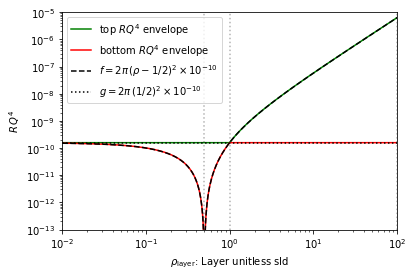

In [144]:
plt.loglog(layer_slds,peaks, 'g-', label = "top $RQ^4$ envelope")
plt.loglog(layer_slds,valleys, 'r-', label = "bottom $RQ^4$ envelope")
plt.loglog(layer_slds,2*np.pi*1e-10*(layer_slds-0.5)**(2),'k--', label = "$f = 2\pi\,(\\rho-1/2)^{2} \\times 10^{-10}$")
plt.axhline(2*np.pi*1e-10*(0.5)**2,c='k', ls=':', label = "$g = 2\pi\,(1/2)^{2} \\times 10^{-10}$")

xmarks = [0.01,0.5,1,100]
plt.xlim([1e-2,1e2])
plt.ylim([1e-13,1e-5])
plt.xlabel("$\\rho_{\\rm layer}$: Layer unitless sld")
plt.ylabel("$R\,Q^4$")
for tick in xmarks:
    plt.axvline(tick, c='k', ls=':', alpha = 0.3)
    
plt.legend()
plt.show()

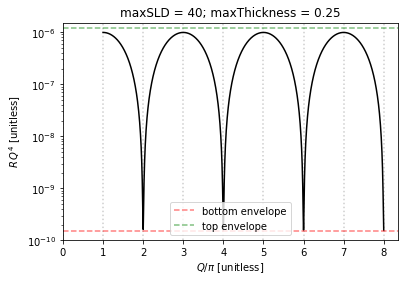

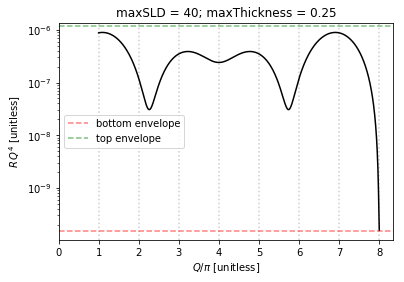

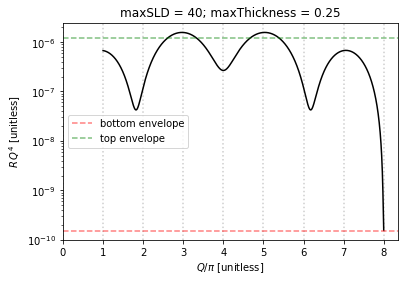

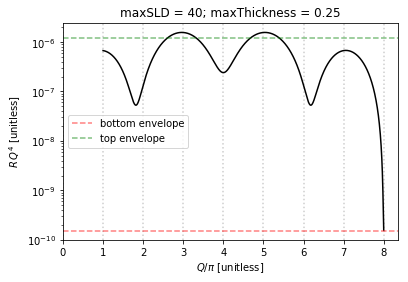

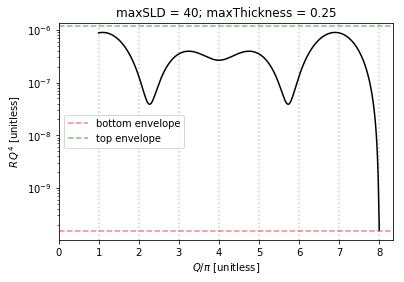

In [160]:
def plot_multilayer_rq4(layer_sld_list, layer_thickness_list):
    
    max_sld = max(layer_sld_list)
    max_thickness = max(layer_thickness_list)

    unit_sld_substrate = 1.0
    unit_q = np.linspace(np.pi, 8.0*np.pi, 2049)
    unitless_layer_slds = [x for x in layer_sld_list] # We have to guess these numbers
    unitless_layer_thicknesses = [x for x in layer_thickness_list] # We have to guess these numbers
    
    unitless_reflectometry = run_layers_over_substrate(unit_sld_substrate, 
                                                    unitless_layer_slds,
                                                    unitless_layer_thicknesses,
                                                    unit_q)
    
    plt.semilogy(unit_q/np.pi, unit_q**4*unitless_reflectometry, 'k-')
    xmarks = [x for x in range(9)]
    plt.xticks(xmarks)
    for tick in xmarks:
        plt.axvline(tick, c='k', ls=':', alpha = 0.2)
        
    plt.axhline(1.5e-10, c='r', ls='--', alpha = 0.5, label = "bottom envelope")
    plt.axhline(7.5e-10*max_sld**2, c='g', ls='--', alpha = 0.5, label = "top envelope")
    plt.xlabel("$Q / \pi \,\, [{\\rm unitless}]$")
    plt.ylabel("$R\,Q^4 \,\, [{\\rm unitless}]$")
    plt.legend()
    plt.title("maxSLD = {}; maxThickness = {}".format(max_sld, max_thickness))
    plt.show()



#LAYER_SLD = 13.0
#LAYER_THICKNESS = 1.0

plot_multilayer_rq4([40,40,40,40], [1/4,1/4,1/4,1/4])
plot_multilayer_rq4([20,40,40,40], [1/4,1/4,1/4,1/4])
plot_multilayer_rq4([40,20,40,40], [1/4,1/4,1/4,1/4])
plot_multilayer_rq4([40,40,20,40], [1/4,1/4,1/4,1/4])
plot_multilayer_rq4([40,40,40,20], [1/4,1/4,1/4,1/4])

## Critical angle:

In [ ]:
LAYER_SLD = 20
LAYER_THICKNESS = 1.0

### Unitless model:

unit_sld_substrate = 1.0
#unit_q = np.linspace(0.007089815402270508, 0.00708981540413086)#4.0*np.pi, 2049)
unit_q = np.linspace(0.0022567583336782723 * np.pi, 0.00225675834 * np.pi, 2049)
unitless_layer_slds = [x for x in [LAYER_SLD]] # We have to guess these numbers
unitless_layer_thicknesses = [x for x in [LAYER_THICKNESS]] # We have to guess these numbers

unitless_reflectometry = run_layers_over_substrate(unit_sld_substrate, 
                                                unitless_layer_slds,
                                                unitless_layer_thicknesses,
                                                unit_q)


critical_angle_approx = 0.5*(unit_q[-1]+unit_q[0])
plt.semilogy(unit_q, unitless_reflectometry, 'k-' ,label = "unitless model")
plt.xticks([critical_angle_approx])
plt.axvline(critical_angle_approx)
print(critical_angle_approx/np.pi)

In [ ]:
LAYER_SLD = 200
LAYER_THICKNESS = 1.0

### Unitless model:

unit_sld_substrate = 1.0
unit_q = np.linspace(0.002 * np.pi, 10, 2049)
unitless_layer_slds = [x for x in [LAYER_SLD]]
unitless_layer_thicknesses = [x for x in [LAYER_THICKNESS]]

unitless_reflectometry = run_layers_over_substrate(unit_sld_substrate, 
                                                unitless_layer_slds,
                                                unitless_layer_thicknesses,
                                                unit_q)

plt.loglog(unit_q, unitless_reflectometry, 'k-' ,label = "unitless model")
#plt.xticks([2*np.pi, 4*np.pi])
#plt.axvline(4*np.pi, c='k', ls=':')
#plt.axvline(2*np.pi, c='k', ls=':')
plt.axvline(0.004*np.pi, c='k', ls=':')
plt.ylim([1e-3,1.0])
plt.xlim([1e-3,1e-1])
plt.show()

In [ ]:
# 1 layer:
x = np.linspace(10,100,10)
n = .15*x
NpeaksVsLayerThickness = np.asarray([[10,1], [20,3], [30,4], [40,6], [50,7], [60,9], [70,11], [80,12], [90,14], [100,15] ]).T

plt.plot(NpeaksVsLayerThickness[0,:],NpeaksVsLayerThickness[1,:],'ko')
plt.plot(x,n,'r-')

In [ ]:
#Experimental setup:

subs_from_experiment = 2.07
q_from_experiment = np.linspace(1e-3, 0.25, 1025)
slds_from_experiment = [x for x in [6, 3, 8, 5]]
thicks_from_experiment = [x for x in [20, 10, 30, 5]]
ref_from_experiment = run_layers_over_substrate(subs_from_experiment, 
                                                slds_from_experiment, 
                                                thicks_from_experiment,
                                                q_from_experiment)

###
        scale_factor = np.sqrt(subs_from_experiment)
        qvals = scale_factor * q_from_experiment
        layers_slds = [scale_factor**2 * x for x in [30,70,50,90]]
        layers_thicknesses = [scale_factor**(-1) * x for x in [20,10,10, 5]]

        ref_signal = run_layers_over_substrate(substrate_sld,layers_slds,layers_thicknesses,qvals)
    
        qvals /= (scale_factor*qmax)
###

#Try fitting:
scale_factor = np.sqrt(subs_from_experiment)
qvals = q_from_experiment / scale_factor
rvals = ref_from_experiment / ref_from_experiment[0]


    
plt.semilogy(q_from_experiment,ref_from_experiment,'k.' ,label = "experiment")
plt.semilogy(qvals,rvals,'b-' ,label = "map")

plt.legend()
plt.xlabel("Q")
plt.ylabel("R")

plt.grid()
plt.show()
    

# Map thickness vs SLD reflectometry for a single Q value

In [ ]:
import matplotlib.colors as colors
for i, q in enumerate(np.linspace(0.1,2,100)):
    plt.figure()
    substrate_sld = 1.0
    factors = np.linspace(-3,3,64)
    thicknesses = np.linspace(1.0,10.0,64)
    roughnesses = np.zeros_like(slds)
    qvals = np.array([q])
    refs = np.array([[run_layer_over_substrate(f*substrate_sld,substrate_sld,t,qvals) for f in factors] for t in thicknesses])
    
    xx, yy = np.meshgrid(factors, thicknesses)
    refs = refs.reshape(xx.shape)
    
    
    # Make the plot
    plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=refs.min(), vmax=refs.max()), cmap='jet')
    plt.colorbar()
    #for s in thicknesses:
    #    plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.', alpha=0.3) 
    plt.xlabel("f = layer sld / substrate sld")
    plt.ylabel("Thickness")
    plt.title("Q="+str(q))
    plt.savefig("sld_factor_{:02}.png".format(i))
    plt.close(fig='all')

In [ ]:
refs.shape

In [ ]:
for i in enumerate(np.linspace(0.1,10,10)):
    print(i[1])

# Lessons learned:

## For a single layer over a substrate:

The substrate has an SLD $\rho_s$ and the layer over it has an SLD $\rho_l = f \, \rho_s$.
 - Vary sld factor $f$ --> Varies the "amplitude" of the kiessing finges; the "frequency" stays the same.
  - $f$ between 0 and 1 invert the position of the peaks/crests; the effect being strongest for $f = 0.5$
  - For $f = 0$ and $f = 1$, the signal has no bumps
  - The signal has two envelope curves of a functional form $ ~ Q^{-4} \, g(f)\, e^{-1.5 \, h(f)}$
 - Vary thickness --> Varies the "frequency" of kiessing fringes, while the "amplitude" stays the same.
 
## Problem scaling -- Self-similarity (applies for any number of layers):

Letting the "natural" unit of the problem to be the $Q$ range, and rescaling it by a factor $\alpha$:

 - $Q_\alpha = \alpha\, Q$,

the same reflectometry signal is obtained if, at the same time, the following scalings are performed:

 - $\{\rho_i\}_\alpha = \{\alpha^2 \, \rho_i\}$
 - $\{d_i\}_\alpha = \{ \alpha^{-1} \, d_i \}$

where $\rho_i$ and $d_i$ are the SLD and the thickness of the set of layers, including the substrate.

Conversely, the natural unit of the problem can be taken as $\rho_s$ --the substrate SLD. In this case, rescaling $\rho_s$ by a factor $\alpha$,

$\rho_{s,\alpha} = \alpha \, \rho_s$,

the same reflectometry signal is obtained by the following rescalings:

 - $Q_\alpha = \sqrt{\alpha}\, Q$,
 - $\{\rho_i\}_\alpha = \{\alpha \, \rho_i\}$
 - $\{d_i\}_\alpha = \{ \alpha^{-1/2} \, d_i \}$.
 
 
# The period depends on the thickness and the amplitude on the SLD:

 - In the natural units defined by the sld of the substrate, the kiessing finges appear with a period $\Delta Q = 2\pi / d$, where $d$ is the thickness of the layer; i.e. thicker layers produce more fringes for the same $Q$ range.
 - The amplitude of the $RQ^4$ signal evidently has a dependence on the sld of the layer on top of the substrate. In this simple example, we use two envelope functions for modelling the top and the bottom of the signal: a constant $1.5 \times 10^{-10}$ for the lower envelope and a function $ \sim \rho_{\rm layer}^2$ for the upper layer.
 
# The envelopes of the signal:

The top and the bottom envelopes of the $RQ^4$ signal vary as function of the layer SLD.

 - top envelope = $\max(f,g)$,
 - bottom envelope = $\min(f,g)$,

where $f$ and $g$ are defined as follows:

$$f = 2\pi\,(\rho-1/2)^{2} \times 10^{-10}$$,
$$g = {\rm const} = 2\pi\,(1/2)^{2} \times 10^{-10}$$
